In [1]:
import findspark
findspark.init()

In [140]:
# Import Libraries

from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.sql.functions import col, udf
from pyspark.ml import Transformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [3]:
# Initiate the Spark Session

spark = SparkSession.builder.appName("Car Prediction Pipeline").getOrCreate()

In [4]:
spark

In [5]:
dataset_url = "https://raw.githubusercontent.com/muttinenisairohith/Datasets/6e7bec3b9cbdc25da1055472c837ef8a10f569ed/data/car_data.csv"

In [ ]:
# In Apache Spark, spark.sparkContext.addFile() is a method used to add a file to the distributed cache, 
# which can then be accessed by all the worker nodes in the Spark cluster.
spark.sparkContext.addFile(dataset_url)

# After adding the file to the distributed cache, it can be accessed using the SparkFiles.get() method, 
# which returns the path to the file on the local filesystem of the worker node
path = SparkFiles.get("car_data.csv")

In [8]:
df = spark.read.csv("file:///"+path, inferSchema=True, header=True)

In [9]:
df.show(5)

+------+------------+-----+-------+--------+------+--------+
|buying|maintainence|doors|persons|lug_boot|safety|car_type|
+------+------------+-----+-------+--------+------+--------+
| vhigh|       vhigh|    2|      2|   small|   low|   unacc|
| vhigh|       vhigh|    2|      2|   small|   med|   unacc|
| vhigh|       vhigh|    2|      2|   small|  high|   unacc|
| vhigh|       vhigh|    2|      2|     med|   low|   unacc|
| vhigh|       vhigh|    2|      2|     med|   med|   unacc|
+------+------------+-----+-------+--------+------+--------+
only showing top 5 rows



In [ ]:
df.printSchema()

root
 |-- buying: string (nullable = true)
 |-- maintainence: string (nullable = true)
 |-- doors: string (nullable = true)
 |-- persons: string (nullable = true)
 |-- lug_boot: string (nullable = true)
 |-- safety: string (nullable = true)
 |-- car_type: string (nullable = true)



<AxesSubplot:xlabel='car_type'>

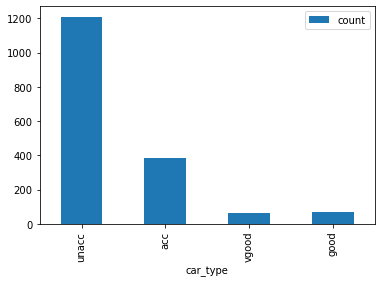

In [ ]:
df.groupBy("car_type").count().toPandas().plot(kind="bar", x="car_type", y='count')

In [138]:
# Split the data

train, test = df.randomSplit([0.8, 0.2], seed=42)

In [139]:
train.count(), test.count()

(1431, 297)

In [13]:
# Defining the column names for to-be encoded columns

colEncoded = [c+"_enc" for c in df.columns] 

In [58]:
# StringIndexer is a feature transformer that encodes a column of string values into a column of numerical values

# The *inputCols* parameter of the StringIndexer constructor specifies the names of the columns in the input DataFrame 
# that should be encoded, and outputCols specifies the names of the corresponding output columns that will contain 
# the encoded values. Both parameters should be specified as lists of column names.

indexer = StringIndexer(inputCols=df.columns, outputCols=colEncoded)

In [77]:
# The given code defines a custom transformer called CastColumns that extends the Transformer class provided by Apache Spark. 
# The purpose of this transformer is to cast the values in one or more columns of a DataFrame to integer data type.

class CastColumns(Transformer):
    def __init__(self, input_cols):
        super(CastColumns, self).__init__()
        self.input_cols = input_cols

    def _transform(self, df):
        for c in self.input_cols:
            df = df.withColumn(c, df[c].cast("int"))
        return df.select(self.input_cols)   

In [84]:
# Defining the constructor

CastFn = CastColumns(input_cols=colEncoded)

In [53]:
# VectorAssembler is a feature transformer that merges multiple columns of a DataFrame into a single vector column.
# the resulting output DataFrame will have a new column called "features" 
# that contains a vector representation of the specified input columns.

assembler = VectorAssembler(inputCols=colEncoded[:-1], outputCol="features")

In [142]:
rfModel = RandomForestClassifier(featuresCol="features", labelCol="car_type_enc")

### Final Model

In [143]:
# Define the pipeline and the sequence of transformers and finally ML Model

model = Pipeline(stages=[indexer, CastFn, assembler, rfModel])

In [95]:
# Define the Evaluation Matric

evaluator = MulticlassClassificationEvaluator(labelCol="car_type_enc")

### Fine-tuning

In [96]:
# ParamGridBuilder is a utility class that is used to construct a grid of hyperparameters to search over during model selection. 
# The hyperparameters should be specified as key-value pairs, where the keys are the names of the hyperparameters and 
# the values are the lists of values to search over.

paramGrid = ParamGridBuilder() \
            .addGrid(rf_clf.numTrees, [100, 200, 300, 400, 500]) \
            .addGrid(rf_clf.maxDepth, [2, 4, 6, 8, 10, 12, 14, 16]) \
            .build()  

In [97]:
# CrossValidator is a built-in class in Apache Spark that performs k-fold cross-validation for model selection.
# It takes a machine learning pipeline or model (specified as an estimator), a grid of hyperparameters to search over 
# (specified as estimatorParamMaps), an evaluation metric (specified as an evaluator), 
# and the number of folds to use in k-fold cross-validation (specified as numFolds), 
# and returns the best model based on the specified evaluation metric.

cross_validator = CrossValidator(estimator=model, 
                                estimatorParamMaps=paramGrid, 
                                evaluator=evaluator, 
                                numFolds=5)

In [98]:
cvModel = cross_validator.fit(train)

In [100]:
predictions = cv_model.transform(test)

In [101]:
evaluator.evaluate(predictions)

0.9569437393492686